<a href="https://colab.research.google.com/github/abdullahamruf/object-detection/blob/main/UCF_50_8__class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
# # Discard the output of this cell.
# %%capture

# # Downlaod the UCF50 Dataset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# #Extract the Dataset
# !unrar x UCF50.rar

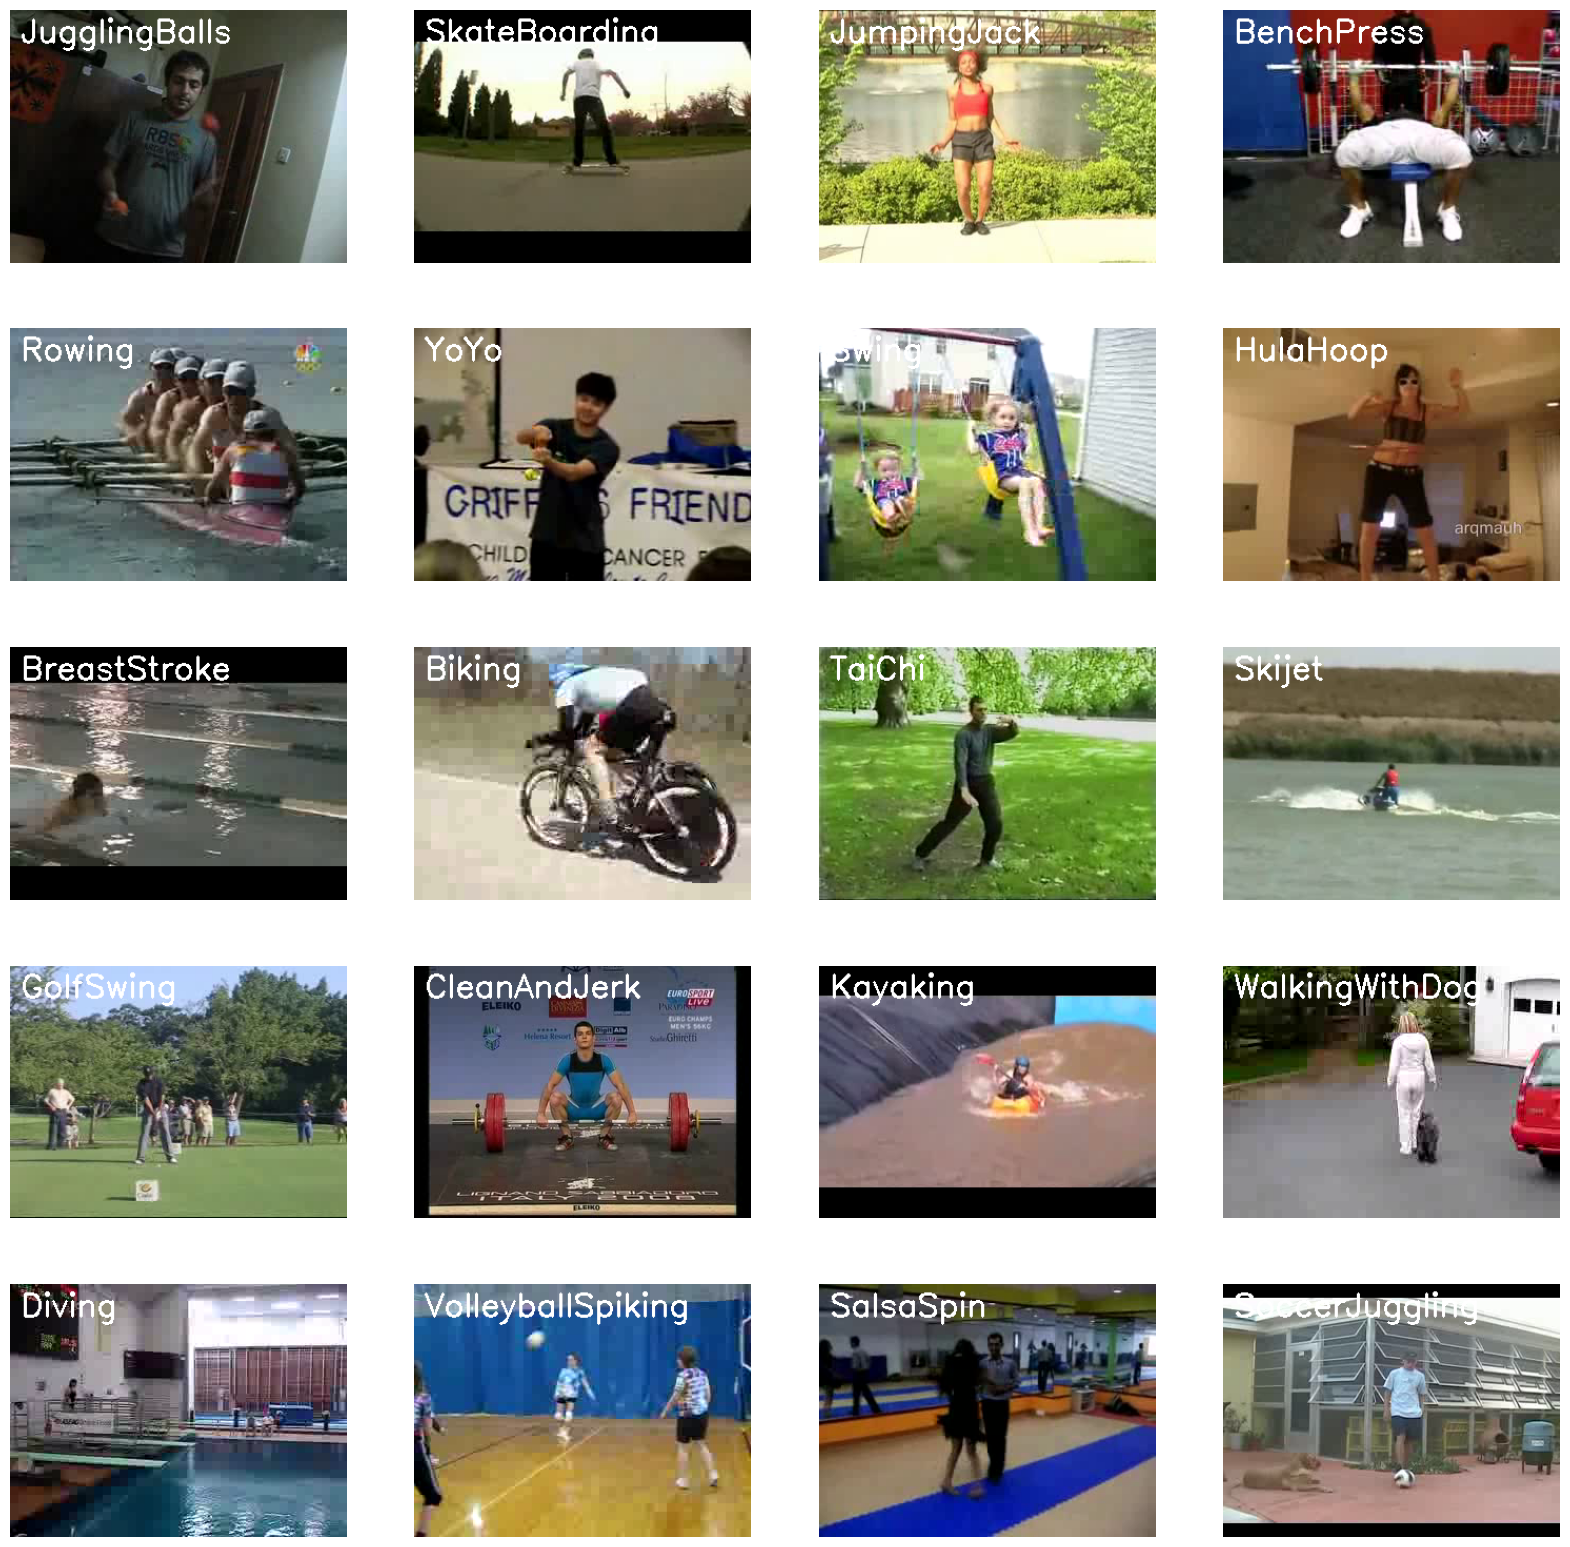

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [11]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 17

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Punch", "Mixing", "Diving", "Biking","SalsaSpin","Skijet","HorseRace","Lunges"]

In [12]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [13]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [14]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Punch
Extracting Data of Class: Mixing
Extracting Data of Class: Diving
Extracting Data of Class: Biking
Extracting Data of Class: SalsaSpin
Extracting Data of Class: Skijet
Extracting Data of Class: HorseRace
Extracting Data of Class: Lunges


In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [16]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [17]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [18]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 17, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 17, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 17, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 17, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 17, 15, 15, 8)     0         
 g3D)                                                            
                                                        

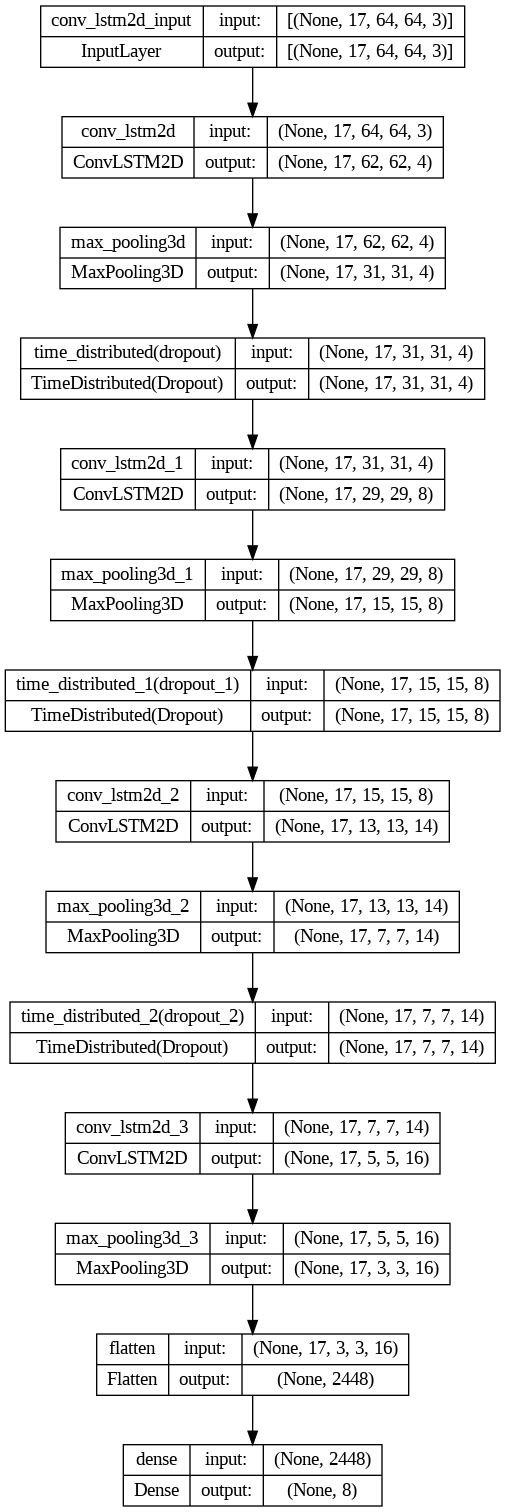

In [19]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [20]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Nadam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
165/165 [==============================] - 39s 157ms/step - loss: 1.8668 - accuracy: 0.2833 - val_loss: 1.5834 - val_accuracy: 0.4000
Epoch 2/50
165/165 [==============================] - 24s 148ms/step - loss: 1.3532 - accuracy: 0.5061 - val_loss: 1.1475 - val_accuracy: 0.5576
Epoch 3/50
165/165 [==============================] - 24s 147ms/step - loss: 1.0511 - accuracy: 0.6485 - val_loss: 0.9655 - val_accuracy: 0.6909
Epoch 4/50
165/165 [==============================] - 24s 147ms/step - loss: 0.8535 - accuracy: 0.6833 - val_loss: 0.8510 - val_accuracy: 0.7091
Epoch 5/50
165/165 [==============================] - 24s 148ms/step - loss: 0.6880 - accuracy: 0.7455 - val_loss: 0.8980 - val_accuracy: 0.7152
Epoch 6/50
165/165 [==============================] - 24s 147ms/step - loss: 0.5394 - accuracy: 0.8136 - val_loss: 0.7735 - val_accuracy: 0.7576
Epoch 7/50
165/165 [==============================] - 24s 148ms/step - loss: 0.4244 - accuracy: 0.8470 - val_loss: 0.6602 - val_ac

In [21]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

9/9 [==============================] - 1s 86ms/step - loss: 0.5782 - accuracy: 0.8473


In [22]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
165/165 [==============================] - 34s 157ms/step - loss: 0.3099 - accuracy: 0.8894 - val_loss: 0.7397 - val_accuracy: 0.7697
Epoch 2/50
165/165 [==============================] - 25s 151ms/step - loss: 0.2141 - accuracy: 0.9303 - val_loss: 0.7083 - val_accuracy: 0.7818
Epoch 3/50
165/165 [==============================] - 24s 148ms/step - loss: 0.1973 - accuracy: 0.9409 - val_loss: 0.7038 - val_accuracy: 0.8182
Epoch 4/50
165/165 [==============================] - 24s 147ms/step - loss: 0.1372 - accuracy: 0.9500 - val_loss: 0.7653 - val_accuracy: 0.7455
Epoch 5/50
165/165 [==============================] - 24s 147ms/step - loss: 0.1072 - accuracy: 0.9652 - val_loss: 0.7536 - val_accuracy: 0.8121
Epoch 6/50
165/165 [==============================] - 24s 146ms/step - loss: 0.1008 - accuracy: 0.9773 - val_loss: 0.8120 - val_accuracy: 0.7818
Epoch 7/50
165/165 [==============================] - 24s 147ms/step - loss: 0.0442 - accuracy: 0.9879 - val_loss: 0.6754 - val_ac

In [23]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
165/165 [==============================] - 34s 161ms/step - loss: 0.0971 - accuracy: 0.9697 - val_loss: 0.8245 - val_accuracy: 0.7697
Epoch 2/50
165/165 [==============================] - 26s 158ms/step - loss: 0.0758 - accuracy: 0.9742 - val_loss: 0.8705 - val_accuracy: 0.7758
Epoch 3/50
165/165 [==============================] - 24s 147ms/step - loss: 0.1182 - accuracy: 0.9591 - val_loss: 0.8805 - val_accuracy: 0.8242
Epoch 4/50
165/165 [==============================] - 24s 148ms/step - loss: 0.0627 - accuracy: 0.9833 - val_loss: 0.8830 - val_accuracy: 0.7939
Epoch 5/50
165/165 [==============================] - 24s 148ms/step - loss: 0.0688 - accuracy: 0.9803 - val_loss: 0.8484 - val_accuracy: 0.8424
Epoch 6/50
165/165 [==============================] - 24s 147ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.7993 - val_accuracy: 0.8606
Epoch 7/50
165/165 [==============================] - 24s 148ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.6444 - val_ac

In [24]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

9/9 [==============================] - 0s 53ms/step - loss: 0.5564 - accuracy: 0.8945


In [25]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



In [26]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [27]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

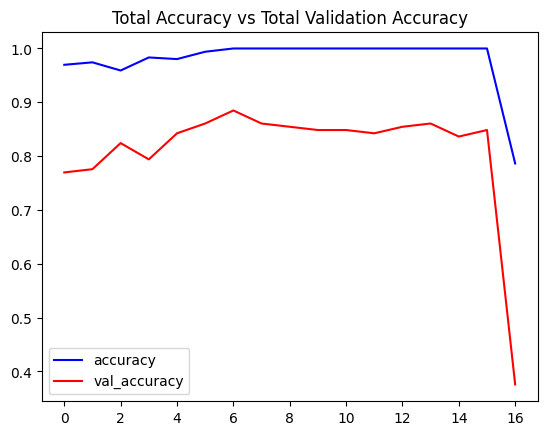

In [28]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [29]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [30]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 17, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 17, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 17, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 17, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 17, 4, 4, 32)     

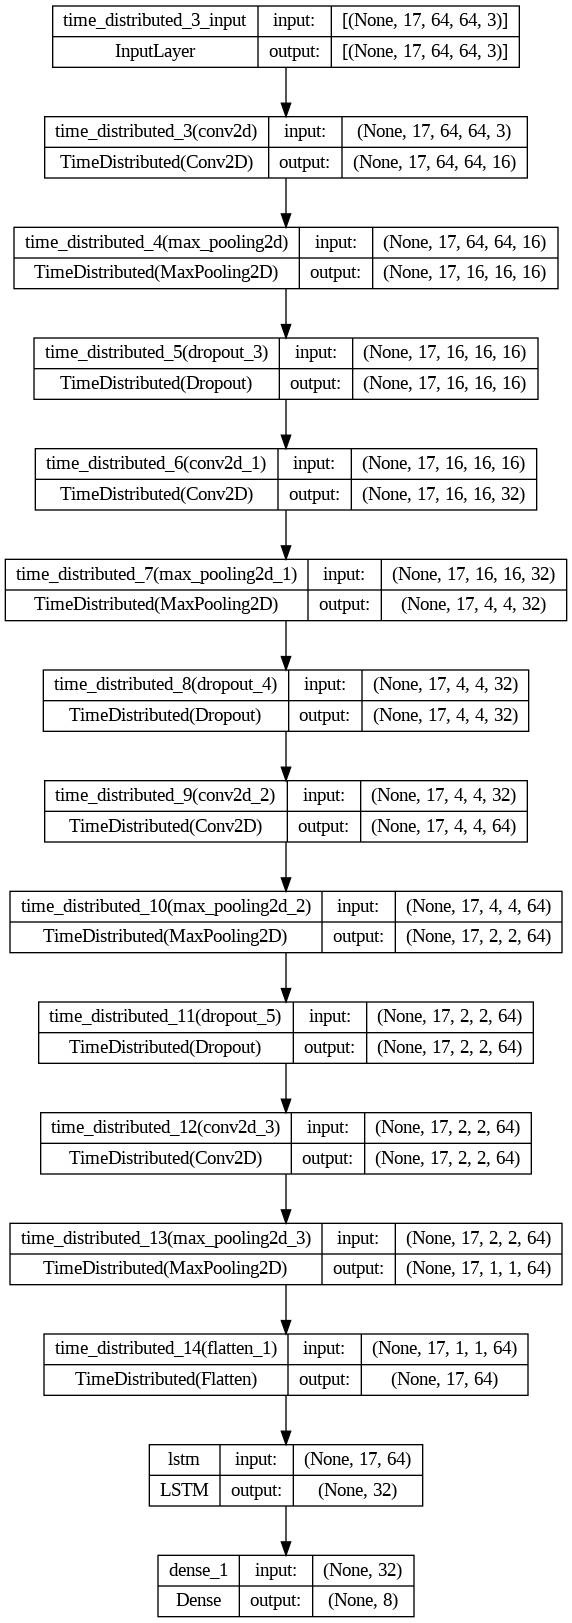

In [31]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [32]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
165/165 [==============================] - 6s 14ms/step - loss: 2.0592 - accuracy: 0.1652 - val_loss: 1.9911 - val_accuracy: 0.2303
Epoch 2/70
165/165 [==============================] - 1s 8ms/step - loss: 1.7561 - accuracy: 0.3318 - val_loss: 1.6100 - val_accuracy: 0.3939
Epoch 3/70
165/165 [==============================] - 1s 8ms/step - loss: 1.5165 - accuracy: 0.3833 - val_loss: 1.5721 - val_accuracy: 0.3455
Epoch 4/70
165/165 [==============================] - 1s 8ms/step - loss: 1.3916 - accuracy: 0.4621 - val_loss: 1.5044 - val_accuracy: 0.3879
Epoch 5/70
165/165 [==============================] - 1s 8ms/step - loss: 1.2612 - accuracy: 0.5121 - val_loss: 1.3544 - val_accuracy: 0.4667
Epoch 6/70
165/165 [==============================] - 1s 8ms/step - loss: 1.1222 - accuracy: 0.5894 - val_loss: 1.2106 - val_accuracy: 0.5879
Epoch 7/70
165/165 [==============================] - 1s 8ms/step - loss: 1.0773 - accuracy: 0.6136 - val_loss: 1.1056 - val_accuracy: 0.5818
Epoch

In [33]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

9/9 [==============================] - 1s 44ms/step - loss: 0.1814 - accuracy: 0.9527


In [34]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
165/165 [==============================] - 5s 13ms/step - loss: 0.0644 - accuracy: 0.9788 - val_loss: 0.4387 - val_accuracy: 0.9030
Epoch 2/70
165/165 [==============================] - 1s 8ms/step - loss: 0.1445 - accuracy: 0.9545 - val_loss: 0.6640 - val_accuracy: 0.8485
Epoch 3/70
165/165 [==============================] - 1s 8ms/step - loss: 0.1527 - accuracy: 0.9500 - val_loss: 0.6759 - val_accuracy: 0.8242
Epoch 4/70
165/165 [==============================] - 1s 8ms/step - loss: 0.1330 - accuracy: 0.9591 - val_loss: 0.3805 - val_accuracy: 0.8788
Epoch 5/70
165/165 [==============================] - 1s 8ms/step - loss: 0.0411 - accuracy: 0.9909 - val_loss: 0.3078 - val_accuracy: 0.9212
Epoch 6/70
165/165 [==============================] - 1s 8ms/step - loss: 0.0222 - accuracy: 0.9955 - val_loss: 0.4893 - val_accuracy: 0.8727
Epoch 7/70
165/165 [==============================] - 1s 8ms/step - loss: 0.1036 - accuracy: 0.9712 - val_loss: 0.2382 - val_accuracy: 0.9333
Epoch

In [35]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

9/9 [==============================] - 0s 13ms/step - loss: 0.2147 - accuracy: 0.9600


In [36]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

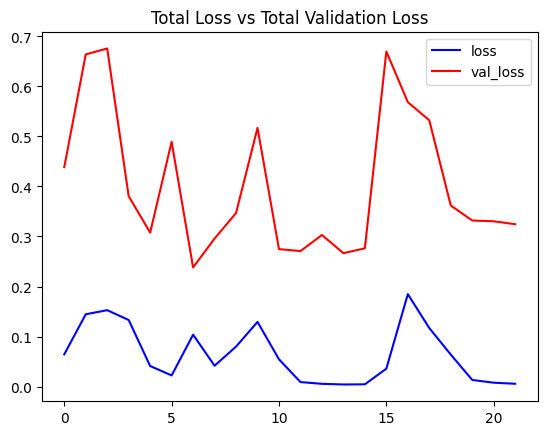

In [37]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

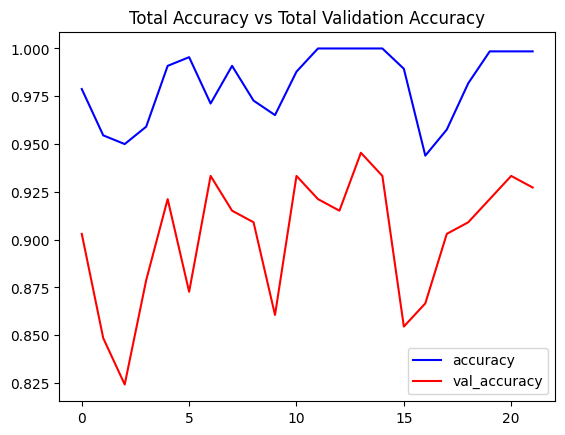

In [38]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [39]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [52]:
test_videos_directory='/content/drive/MyDrive/Colab Notebooks/CnvLstm/test_video'
video_title='biking'
input_video_file_path = '/content/drive/MyDrive/Colab Notebooks/test_video/biking.mp4'

In [53]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  99%|█████████▉| 119/120 [00:00<00:00, 399.87it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/Colab Notebooks/CnvLstm/test_video/biking-Output-SeqLen17.mp4, 151200 bytes wanted but 0 bytes read,at frame 119/120, at time 3.97/3.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [44]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have a trained model called 'model' and test data 'X_test' and 'y_test'

# Predict probabilities for the test set
y_pred_proba = convlstm_model.predict(features_train)

# Convert probabilities to binary classes (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Convert y_test to binary classes if it's not already
# (Assuming it's a binary classification task)
y_true = (labels_train > 0.5).astype(int)
target_type = labels_train.shape[1]
# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


26/26 [==============================] - 3s 69ms/step
Precision: 0.9792935444579781
Recall: 0.9745454545454545
F1-score: 0.9769137302551639


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have a trained model called 'model' and test data 'X_test' and 'y_test'

# Predict probabilities for the test set
y_pred_proba = convlstm_model.predict(features_train)

# Convert probabilities to binary classes (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Convert y_test to binary classes if it's not already
# (Assuming it's a binary classification task)
y_true = (labels_train > 0.5).astype(int)
target_type = labels_train.shape[1]
# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


26/26 [==============================] - 1s 52ms/step
Precision: 0.9792935444579781
Recall: 0.9745454545454545
F1-score: 0.9769137302551639


In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

learning_rate = 0.001  # You can adjust this value

# Compile the model and specify loss function, optimizer and metrics to the model.
optimizer = Adam(learning_rate=learning_rate)  # Use Adam optimizer with specified learning rate
LRCN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=17, batch_size=4,
                                             shuffle=True, validation_split=0.1, callbacks=[early_stopping_callback])

Epoch 1/17
186/186 [==============================] - 5s 12ms/step - loss: 0.0089 - accuracy: 0.9960 - val_loss: 0.4109 - val_accuracy: 0.9398
Epoch 2/17
186/186 [==============================] - 1s 8ms/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.4489 - val_accuracy: 0.9277
Epoch 3/17
186/186 [==============================] - 1s 8ms/step - loss: 0.0507 - accuracy: 0.9892 - val_loss: 0.1372 - val_accuracy: 0.9639
Epoch 4/17
186/186 [==============================] - 2s 8ms/step - loss: 0.0275 - accuracy: 0.9919 - val_loss: 0.1817 - val_accuracy: 0.9639
Epoch 5/17
186/186 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2582 - val_accuracy: 0.9518
Epoch 6/17
186/186 [==============================] - 1s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2995 - val_accuracy: 0.9518
Epoch 7/17
186/186 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9518
Epoch

In [74]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

9/9 [==============================] - 0s 16ms/step - loss: 0.1821 - accuracy: 0.9709


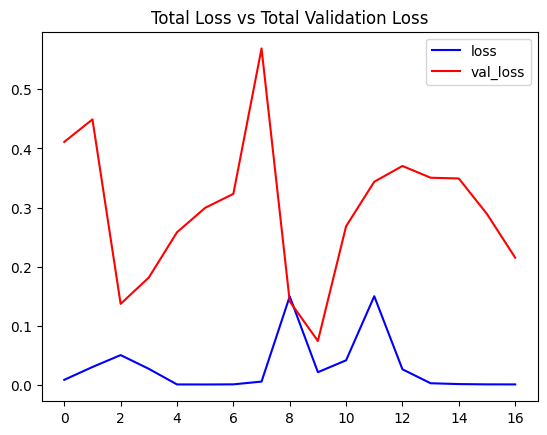

In [75]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

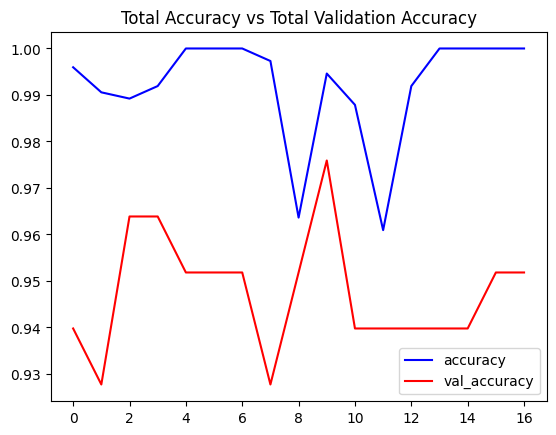

In [76]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')